In [1]:
#!/usr/bin/python

import sys
import pickle
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

c:\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
### Load the dictionary containing the dataset
# pickle compatible with python3
with open("final_project_dataset_python3.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

## Explorando os dados

### Análise das Características e Remoção de Outliers

Para manter os dados ainda compatíveis com o `tester.py` na análise será
realizado sobre um dataframe, porém posteriormente será aplicado os ajustes
no dicionário.

In [3]:
data_df = pd.DataFrame.from_dict(data_dict).T

# seleciona as colunas que não são numéricas
cols_string = ['email_address', 'poi']
cols = list(data_df)

# seleciona as variáveis numéricas
cols_numeric = np.setdiff1d(cols, cols_string)

# transforma os valores em números e quando 'NaN' em NaN
data_df[cols_numeric] = data_df[cols_numeric].apply(pd.to_numeric, errors='coerce')
data_df['poi'] = data_df['poi'].astype('bool')

#### Características principais dos dados

Iniciamos pela observação dos dados para entrender suas dimensões, quantidade
de observações e a variância de cada característica.

In [4]:
# sumário dos dados transposto para melhor visualização
summary_data_df = data_df.describe().T[['count', 'min', 'mean', 'max']]
print(summary_data_df)
print("")
print("- Tamanho dos dados (observações, variáveis): {}".format(data_df.shape))
print("- Quantidade de Poi: {}".format(sum(data_df['poi'])))
print("- Quantidade de Não-Poi: {}".format(len(data_df.index)))
print("- Relação de Poi / Não-Poi: {:.4} %".format(sum(data_df['poi']) \
                                                   / len(data_df.index) * 100))
print("- Características menos de 15% valores presente:\n {}".format(\
    list(summary_data_df[summary_data_df['count'] < 0.15 * len(data_df.index)].index)))

                           count         min          mean          max
bonus                       82.0     70000.0  2.374235e+06   97343619.0
deferral_payments           39.0   -102500.0  1.642674e+06   32083396.0
deferred_income             49.0 -27992891.0 -1.140475e+06       -833.0
director_fees               17.0      3285.0  1.668049e+05    1398517.0
exercised_stock_options    102.0      3285.0  5.987054e+06  311764000.0
expenses                    95.0       148.0  1.087289e+05    5235198.0
from_messages               86.0        12.0  6.087907e+02      14368.0
from_poi_to_this_person     86.0         0.0  6.489535e+01        528.0
from_this_person_to_poi     86.0         0.0  4.123256e+01        609.0
loan_advances                4.0    400000.0  4.196250e+07   83925000.0
long_term_incentive         66.0     69223.0  1.470361e+06   48521928.0
other                       93.0         2.0  9.190650e+05   42667589.0
restricted_stock           110.0  -2604490.0  2.321741e+06  1303

Pode ser notado que algumas das variáveis não podemos utilizar pela grande
quantidade de informação faltando. Isso ocorre principalmente para as
variáveis `director_fees`, `loan_advances` e `restricted_stock_deferred`.

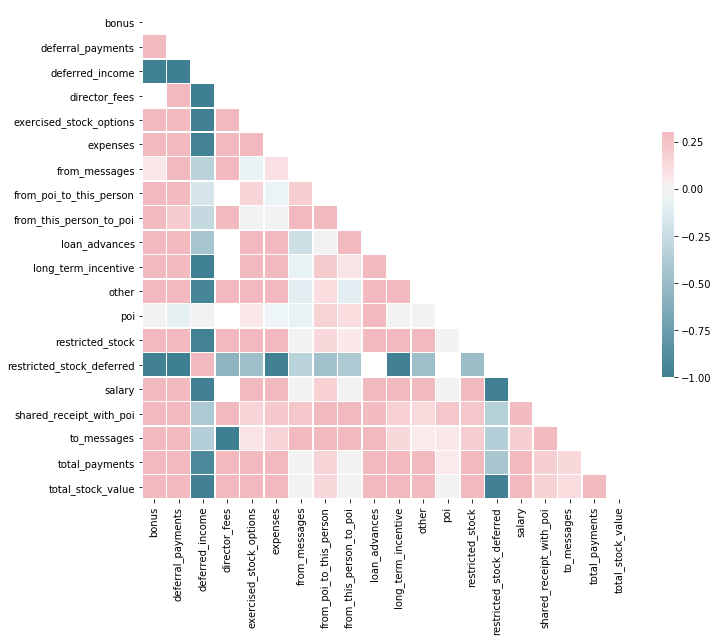

In [5]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
corr = data_df.corr()

# cria uma máscara para o triangulo superior
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# configura o plt
f, ax = plt.subplots(figsize=(11, 9))

# cria as cores para as relações
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# desenha o gráfico com a relação de cores associadas com a correlação
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [6]:
def tag_outlier(df, columns):
    """ Identifica possíveis outliers, colocado um range maior
        para um outlier visto que os dados possuem uma grande 
        variância, e a identificação de poi está associada a 
        valores extremos.
    Args:
        variable: pandas dataframe
    Returns:
        row index
    Raises:
    """
    def column_outlier_eval(variable):
        q1, q3 = variable.quantile([.25, .75])
        inter_q = q3 - q1
        max_val = q3 + 5 * inter_q
        min_val = q1 - 5 * inter_q
        return variable[(variable > max_val) | (variable < min_val)].index

    rows_to_look = []
    for var in columns:
        rows_to_look.append(list(column_outlier_eval(df[var])))

    possible_outlier = np.unique([j for i in rows_to_look for j in i])
    return possible_outlier

def too_many_nan(df, qty_limit):
    """ Identifica as linhas com muitos NaN
    Args:
        variable: pandas dataframe
    Returns:
        row index
    Raises:
    """
    qty_nan = df.isnull().sum(axis=1)
    print(qty_nan.loc[qty_nan > qty_limit].sort_values())
    

In [7]:
tag_outlier(data_df, cols_numeric)
too_many_nan(data_df, 16)

GRAMM WENDY L                    17
SCRIMSHAW MATTHEW                17
THE TRAVEL AGENCY IN THE PARK    17
WHALEY DAVID A                   17
WODRASKA JOHN                    17
WROBEL BRUCE                     17
LOCKHART EUGENE E                19
dtype: int64


In [8]:
print(data_df.loc['LOCKHART EUGENE E'])

bonus                          NaN
deferral_payments              NaN
deferred_income                NaN
director_fees                  NaN
email_address                  NaN
exercised_stock_options        NaN
expenses                       NaN
from_messages                  NaN
from_poi_to_this_person        NaN
from_this_person_to_poi        NaN
loan_advances                  NaN
long_term_incentive            NaN
other                          NaN
poi                          False
restricted_stock               NaN
restricted_stock_deferred      NaN
salary                         NaN
shared_receipt_with_poi        NaN
to_messages                    NaN
total_payments                 NaN
total_stock_value              NaN
Name: LOCKHART EUGENE E, dtype: object


Observando os dados podemos observar o aparecimento de uma pessoa chamada
`TOTAL` o que nos aponta para um provável erro de digitação que podemos
eliminar dos dados.

Outro ponto é o aparecimento de uma agencia de viagens nos dados
`THE TRAVEL AGENCY IN THE PARK` que ao não representar uma pessoa será removido.

Por último temos uma pessoa chamada `LOCKHART EUGENE E` que não possuímos
nenhuma informação referente, assim também será removido.

In [9]:
items_to_drop = ['TOTAL','THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E']
for outlier in items_to_drop:
    data_dict.pop(outlier, 0)
    
data_df.drop(items_to_drop, inplace=True)

### Criação de Novas Variáveis

Ao observar apenas as quantidades totais de e-mails, perdemos a sensibilidade na
compreensão dos indivíduos com baixa quantidade de e-mails. Porém esses indivíduos
podem possuir uma significância maior no seu relacionamento com os poi, o qual
podendo ajudar na classificação de poi ou não-poi. 

Desta forma a criação de novas variáveis será utilizado a relação entre a quantidade
de e-mails enviados para `poi` sobre o total de e-mails enviada por cada pessoa, 
capturando o percentual de e-mails enviados para poi.

In [10]:
if_nan_make_zero = lambda x : 0 if x == 'NaN' else x 

for poi in data_dict:
    if data_dict[poi]['to_messages'] == 'NaN':
        data_dict[poi]['msg_to_poi_prec'] = 0
    else:
        data_dict[poi]['msg_to_poi_prec'] = if_nan_make_zero(data_dict[poi]['from_this_person_to_poi']) / \
                                if_nan_make_zero(data_dict[poi]['to_messages'])

data_df['msg_to_poi_prec'] = data_df['from_this_person_to_poi'] / data_df['to_messages']

### Avaliação das Variáveis


Primeiro vamos avaliar as variáveis disponíveis pelo score relativo ao `poi`. 
Isso é feito utilizando o `SelectBest` e observando o score obtido pelo `fit`
do modelo.

In [11]:
# seleciona as colunas que não são numéricas
cols_remove = ['email_address', 'poi']
cols = list(data_df)

# de todas as colunas, selecionamos as que são numéricas
cols_features = np.setdiff1d(cols, cols_remove)

features = data_df.loc[:, cols_features]
features.fillna(0, inplace=True)

labels = data_df.loc[:, 'poi']

from sklearn.feature_selection import SelectKBest

selector = SelectKBest(k=2)
selector.fit(features, labels)

SelectKBest(k=2, score_func=<function f_classif at 0x00000236AA3689D8>)

In [12]:
features_scores = pd.Series(list(features))
features_scores = pd.concat([features_scores.reset_index(drop=True), 
                             pd.Series(selector.scores_)], axis=1)
features_scores.columns = ['variable', 'score']
features_scores.set_index('variable', inplace=True)

# vamos guardar a sequencia das variáveis para a avaliacao nos modelos
features_sequence = features_scores.sort_values(by=['score'], ascending=False)
print(features_sequence)

                               score
variable                            
exercised_stock_options    24.815080
total_stock_value          24.182899
bonus                      20.792252
salary                     18.289684
deferred_income            11.458477
long_term_incentive         9.922186
restricted_stock            9.212811
total_payments              8.772778
shared_receipt_with_poi     8.589421
loan_advances               7.184056
expenses                    6.094173
from_poi_to_this_person     5.243450
other                       4.187478
msg_to_poi_prec             4.094653
from_this_person_to_poi     2.382612
director_fees               2.126328
to_messages                 1.646341
deferral_payments           0.224611
from_messages               0.169701
restricted_stock_deferred   0.065500


Ao observar os scores, podemos observar que 4 dos mesmos possuem notas
razoáveis acima de 10, sendo as variáveis que serão utilizadas para a
avaliação inicial dos modelos. Uma avaliação da contribuição do incremento
da utilização das variáveis será realizado sobre o modelo selecionado.

Outro método que será avaliado é a utilização do PCA para a redução de
dimensões dos nossos dados. Para entender a quantidade de dimensões que
devemos escolher, podemos observar a variância das dimensões. A variância
está relacionada a quantidade de informação que cada componente do PCA
agrega ao modelo.

A variável criada anteriormente acaba não retornando uma boa classificação,
assim como todas as variáveis relacionadas a e-mails.

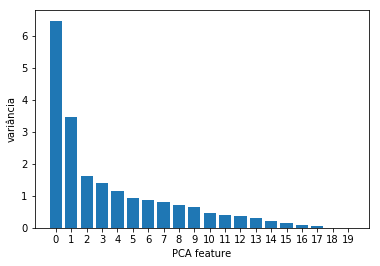

In [13]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scalar, pca)

pipeline.fit(features)

features_qty = range(pca.n_components_)
plt.bar(features_qty, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variância')
plt.xticks(features_qty)
plt.show()

Podemos assumir que com 5 componentes do PCA podemos uma quantidade de
informação para explicar os dados. A partir do quinto componente existe
uma variação muito baixa de variância indicando uma baixa agregação de
informação.

### Metrica de avaliação dos modelos

Os dados apresentam um bias muito grande na relação de poi e não poi

Existem apenas 18 poi, o que acarreta que a métrica de acurácia irá
favorecer modelos com altas indicações de não poi, sendo que um modelo
que indique não poi para todos consegue ~87% acurácia.

Para evitar não favorecer um grande aparecimento de *False Negative*
(os casos de poi classificados como não poi) utilizaremos como
principal métrica o ***recall***. O mesmo indica qual a probabilidade
do modelo indicar um poi corretamente.
O *recall* possui sua fórmula:

$$TruePositives / (TruePositives + FalseNegatives)$$

Assim aumentando o denominador nos casos do aparecimento de *False
Negatives* que são os casos que um não poi são identificados como poi.

A segunda métrica a ser avaliada é a ***precision***, visto que dado
uma classificação de um item como poi, o mesmo ser realmente poi.
O *precision* possui sua fórmula:

$$TruePositives / (TruePositives + FalsePositive)$$

Como possui no denominador os *False Positives* penaliza os casos onde
um poi é classificado como não poi.

### Pipelines dos modelos iniciais

Os dados apresentam grandes variações de magnitude, assim será aplicado um
escalonamento das variáveis nos pipelines para que não afete os modelos 
sensíveis a essas variações.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [15]:
def tester(clf, sss, features, labels):
    """ Realiza a avaliação do modelo de classificação igual ao
    teste fornecido em tester.py porém usando python3 e pandas
    Args:
        clf: classificador
        sss: split dos dados por StratifiedShuffleSplit
        features: pandas df com as variáveis
        labels: pandas df com o target
    Returns:
        não há retorno, apenas um print da avaliação do modelo
    Raises:
    """

    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    
    for train_index, test_index in sss.split(features, labels):
        features_train, features_test = features.iloc[train_index], features.iloc[test_index]
        labels_train, labels_test = labels.iloc[train_index], labels.iloc[test_index]

        clf.fit(features_train, labels_train)
        pred = clf.predict(features_test)
    
        for prediction, truth in zip(pred, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
    
    total_predictions = true_negatives + false_negatives + false_positives + true_positives
    accuracy = 1.0 * (true_positives+true_negatives) / total_predictions
    
    if (true_positives+false_positives) > 0:
        precision = 1.0 * true_positives / (true_positives+false_positives)
    else:
        precision = 0
   
    if (true_positives + false_negatives) > 0:
        recall = 1.0 * true_positives / (true_positives+false_negatives)
    else:
        recall = 0
    
    if (true_positives + false_positives + false_negatives) > 0:
        f1 = 2.0 * true_positives/(2*true_positives+false_positives+false_negatives)
    else:
        f1 = 0
    
    if precision + recall > 0:
        f2 = (1+2.0*2.0) * precision * recall / (4*precision+recall)
    else:
        f2 = 0
    
    results = {'total_predictions' : total_predictions, 
               'accuracy' : accuracy, 
               'f1' : f1, 
               'f2' : f2, 
               'precision' : precision, 
               'recall' : recall,
               'true_negatives' : true_negatives, 
               'false_negatives' : false_negatives, 
               'false_positives' : false_positives, 
               'true_positives' : true_positives}
    
    return results 

Vamos criar 2 grupos de variáveis. O primeiro sendo as variáveis que selecionamos
anteriormente como as mais importantes `features_select`. O segundo sendo todas as
variáveis disponíveis `features_total`, para utilização do PCA e na referência de 
como a seleção se comporta frente ao todo.

In [16]:
# seleção para avaliação inicial dos modelos
cols = ['exercised_stock_options', 'total_stock_value', 'bonus', 'salary']
features_select = data_df.loc[:, cols].fillna(0)

cols_remove = ['email_address', 'poi']
cols = list(data_df)
cols_features = np.setdiff1d(cols, cols_remove)
features_total = data_df.loc[:, cols_features].fillna(0)

labels_poi = data_df.loc[:, 'poi']

### Validação dos Dados

A validação dos dados é essencial para que a validação dos modelos
seja executada sobre dados os quais o modelo ainda não tenha observado.
Se fosse utilizado os mesmos dados de treino para testar os modelos
teríamos um bias nos scores obtidos. 

Porém para nosso conjunto de dados temos dois problemas iniciais na
separação do conjunto de treinamento e teste. 

 - Pequena quantidade de observações.
 - Pequena quantidade de poi frente a não poi
 
Esses dois fatores causam que uma separação única dos dados possa
levar que uma grande quantidade dos pois ocorram em apenas um dos
conjuntos.

Para contornar esse problema os dados serão testados n vezes, tendo
que em cada uma das aplicações do modelo será fornecido uma fração
dos dados para o treinamento e o restante reservado para os testes.
Em cada iteração a separação é realizada de forma diferente.

Esse método de separação do conjunto de treinamento e teste multiplas
vezes é obtido com a função `StratifiedShuffleSplit` presente no
`sklearn.model_selection`.

In [17]:
# criação do shuffle dos dados com seed fixo para replicação
sss = StratifiedShuffleSplit(n_splits = 1000, random_state = 42)

# variavel para guardar todos os testes realizados durante as análises
results = pd.DataFrame(columns=['total_predictions', 'accuracy', 'f1', 'f2', 'precision', 'recall',
              'true_negatives', 'false_negatives', 'false_positives', 'true_positives'])

### Aplicação de Classificadores

#### Gaussian Naive Bayes 

Primeiramente vamos aplicar o GaussianNB com todas as variáveis disponíveis.

Em todos os modelos de GaussianNB será utilizado duas escalas nos dados. Isso
é importante pois é um algoritmo que calcula a distancia entre as características,
dessa forma se não for realizado, variáveis com um intervalo menor de valor
sofrem de uma perda de representatvidade.

Para a escala serão utilizados dois métodos, o primeiro `StandardScaler` para 
retirar o efeito de escala entre as variáveis mantendo a variância, e o segundo
sendo `MinMaxScaler`, o qual ajudar em variáveis com variações muito extremas.

In [18]:
clf = make_pipeline(StandardScaler(), 
                    GaussianNB())
clf_mm = make_pipeline(MinMaxScaler(), 
                    GaussianNB())
clf_pca = make_pipeline(StandardScaler(), 
                        PCA(n_components=5), 
                        GaussianNB())

results = results.append(pd.DataFrame(tester(clf, sss, features_total, labels_poi), 
                                      index=['GNB_std_scalar_all_variables']))
results = results.append(pd.DataFrame(tester(clf, sss, features_select, labels_poi),
                                      index=['GNB_std_scalar_selected_variables']))
results = results.append(pd.DataFrame(tester(clf_mm, sss, features_total, labels_poi), 
                                      index=['GNB_mm_scalar_all_variables']))
results = results.append(pd.DataFrame(tester(clf_mm, sss, features_select, labels_poi),
                                      index=['GNB_mm_scalar_selected_variables']))
results = results.append(pd.DataFrame(tester(clf_pca, sss, features_total, labels_poi),
                                      index=['GNB_std_scalar_pca_n_5']))

#### Support Vector Machine (SVM)

Semelhante ao Gaussian Naive Bayes, o SVM realiza calculo de distância entre
variáveis, assim sendo necessário a utilização das escalas nos inputs.

In [19]:
clf = make_pipeline(StandardScaler(), 
                    SVC())
clf_mm = make_pipeline(MinMaxScaler(), 
                    SVC())
clf_pca = make_pipeline(StandardScaler(), 
                        PCA(n_components=5), 
                        SVC())

results = results.append(pd.DataFrame(tester(clf, sss, features_total, labels_poi),
                                      index=['SVM_std_scalar_all_variables']))
results = results.append(pd.DataFrame(tester(clf, sss, features_select, labels_poi),
                                      index=['SVM_std_scalar_selected_variables']))
results = results.append(pd.DataFrame(tester(clf_mm, sss, features_total, labels_poi),
                                      index=['SVM_mm_scalar_all_variables']))
results = results.append(pd.DataFrame(tester(clf_mm, sss, features_select, labels_poi),
                                      index=['SVM_mm_scalar_selected_variables']))
results = results.append(pd.DataFrame(tester(clf_pca, sss, features_total, labels_poi),
                                      index=['SVM_std_scalar_pca_n_5']))

#### Decision Tree Classifier

Como esse modelo não executa um calculo de distância, não é necessário aplicar
a etapa de escala nas variáveis.

In [20]:
clf = DecisionTreeClassifier(random_state=0)
clf_pca = make_pipeline(PCA(n_components=5), 
                        DecisionTreeClassifier(random_state=0))

results = results.append(pd.DataFrame(tester(clf, sss, features_total, labels_poi),
                                      index=['DT_all_variables']))
results = results.append(pd.DataFrame(tester(clf, sss, features_select, labels_poi),
                                      index=['DT_selected_variables']))
results = results.append(pd.DataFrame(tester(clf_pca, sss, features_total, labels_poi),
                                      index=['DT_pca_n_5']))

In [21]:
results

,accuracy,f1,f2,false_negatives,false_positives,precision,recall,total_predictions,true_negatives,true_positives
GNB_std_scalar_all_variables,0.388733,0.262527,0.442684,368,8801,0.156427,0.8160,15000,4199,1632
GNB_std_scalar_selected_variables,0.854600,0.386498,0.359498,1313,868,0.441801,0.3435,15000,12132,687
GNB_mm_scalar_all_variables,0.468600,0.288494,0.469686,384,7587,0.175595,0.8080,15000,5413,1616
GNB_mm_scalar_selected_variables,0.854600,0.386498,0.359498,1313,868,0.441801,0.3435,15000,12132,687
GNB_std_scalar_pca_n_5,0.831800,0.272282,0.249287,1528,995,0.321745,0.2360,15000,12005,472
SVM_std_scalar_all_variables,0.866667,0.000000,0.000000,2000,0,0.000000,0.0000,15000,13000,0
SVM_std_scalar_selected_variables,0.859533,0.000000,0.000000,2000,107,0.000000,0.0000,15000,12893,0
SVM_mm_scalar_all_variables,0.866667,0.000000,0.000000,2000,0,0.000000,0.0000,15000,13000,0
SVM_mm_scalar_selected_variables,0.866733,0.001000,0.000625,1999,0,1.000000,0.0005,15000,13000,1
SVM_std_scalar_pca_n_5,0.865933,0.000000,0.000000,2000,11,0.000000,0.0000,15000,12989,0


O algoritmo de Gaussian Naive Bayes apresenta resultados melhores quando utilizado
as variáveis selecionadas frente a utilização do PCA e da utilização de todas as
variáveis. Com as variáveis selecionadas podemos observar que os valores da precisão
e do recall então dentro das margens solicitadas para o projeto de 0.3 em ambos.

O SVM com inicialmente nos retorna resultados ruins para os *True Positives*,
isso é um fator que pode ser avaliado posteriormente na melhora do modelo por
meio de ajuste dos hyper-parâmetros para aumentar a penalidade nos "erros".
Com isso pode ser melhorado as estimativas para reduzir os *False Negatives* e
melhorar o *True Positives*.

Por meio do Decision Tree obtemos resultados próximos aos desejados, sendo que a
utilização das variáveis selecionadas com uma pequena vantagem sobre a utilização
do PCA.

### Seleção Final das Variáveis

In [22]:
clf = make_pipeline(StandardScaler(), 
                    GaussianNB())

features_select_sequence = {}
for i in range(0, len(features_sequence.index)):
    features_select_sequence[i] = list(features_sequence.index[0:i+1])
    features_select = data_df.loc[:, features_select_sequence[i]].fillna(0)
    
    results = results.append(pd.DataFrame(tester(clf, sss, features_select, labels_poi),
                                      index=['GNB_std_scalar_{}_variables'.format(i)]))

In [23]:
results.tail(19)

,accuracy,f1,f2,false_negatives,false_positives,precision,recall,total_predictions,true_negatives,true_positives
GNB_std_scalar_1_variables,0.857733,0.344595,0.303047,1439,695,0.446656,0.2805,15000,12305,561
GNB_std_scalar_2_variables,0.853267,0.384336,0.358747,1313,888,0.436190,0.3435,15000,12112,687
GNB_std_scalar_3_variables,0.854600,0.386498,0.359498,1313,868,0.441801,0.3435,15000,12132,687
GNB_std_scalar_4_variables,0.866600,0.442774,0.414451,1205,796,0.499686,0.3975,15000,12204,795
GNB_std_scalar_5_variables,0.857000,0.416961,0.396219,1233,912,0.456820,0.3835,15000,12088,767
GNB_std_scalar_6_variables,0.859000,0.434341,0.416881,1188,927,0.466935,0.4060,15000,12073,812
GNB_std_scalar_7_variables,0.841000,0.347112,0.328395,1366,1019,0.383545,0.3170,15000,11981,634
GNB_std_scalar_8_variables,0.835600,0.337097,0.322531,1373,1093,0.364535,0.3135,15000,11907,627
GNB_std_scalar_9_variables,0.771200,0.272881,0.300373,1356,2076,0.236765,0.3220,15000,10924,644
GNB_std_scalar_10_variables,0.772600,0.274101,0.300963,1356,2055,0.238607,0.3220,15000,10945,644


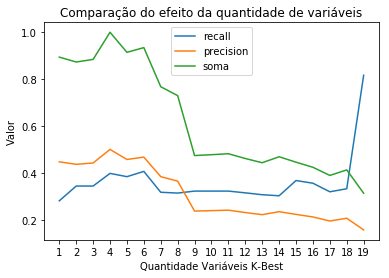

In [24]:
# criar um plot dos ultimos 19 testes obtidos comparando recall e precision
plt.plot(list(range(1, 20)),
         results[['recall']].tail(19), label='recall')
plt.plot(list(range(1, 20)),
         results[['precision']].tail(19), label='precision')
plt.plot(list(range(1, 20)),
         results[['precision']].tail(19) + results[['precision']].tail(19), label='soma')
plt.xticks(np.arange(1, 20, 1.0))
plt.xlabel('Quantidade Variáveis K-Best')
plt.ylabel('Valor')
plt.title('Comparação do efeito da quantidade de variáveis')
plt.legend()

plt.show()

Podemos observar que com o aumento da quantidade de variáveis existe uma
perda gradativa da precisão do modelo. O modelo obtém a melhor soma dos
indicadores desejados com 4 variáveis.

In [25]:
cols = list(features_select_sequence[3])
features_select = data_df.loc[:, cols].fillna(0)

# seleção das variáveis para aplicar no tester.py
# a primeira variável necessita ser o poi
features_list = ['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'salary']

In [26]:
# aloca em my_dataset sendo a variável esperada pelas funções
# fornecidas
my_dataset = data_dict

In [27]:
### extração dos dados utilizando funções fornecidas
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Melhora do Modelo pelos Parâmetros

Cada modelo possui pararâmetros os quais não são avaliados durante o processo
de treinamento, sendo definidos na criação do classificador. Esses parâmetros
são chamados de hiperparâmetros, e causam um grande impacto na capacidade de
previsão do modelo. Até o momento foram utilizados os parâmetros default de
cada modelo, assim nessa última etapa será feiro o refinamento para encontrar
os melhores parâmetros para o modelo selecionado.

Mesmo o Naive Bayes (NB) tendo os melhores resultados até o momento, iremos
tentar melhorar por meio de procura de parâmetros o SVM pois o NB é um dos
poucos modelos que não possuem hiperparâmetros para serem avaliados.

In [28]:
steps = [('scaler', StandardScaler()),
         ('svc', SVC())]

pipeline = Pipeline(steps)

# seleção dos hyper-parâmetros a serem testados
# foi selecionado opcoes de alto C para contra balançar o
# baixo True Positive observado no teste inicial
parameters = {'svc__kernel': ('rbf', 'linear'),
            'svc__gamma':  ['auto', 0.6, 0.7, 0.8, 0.9, 1.0],
            'svc__C': [100.0, 1000.0, 10000.0, 20000.0],
             }

# usamos uma quantidade menor de splits devido a quantidade resultante
# de combinações o que tomaria um tempo extremamente longo
sss = StratifiedShuffleSplit(n_splits = 50, random_state = 42)

# definição do GridSearchCV
clf = GridSearchCV(pipeline, parameters, cv=sss.split(features, labels), 
                   n_jobs = 5, scoring = 'recall', verbose = 3)

clf.fit(features, labels)

print("Melhores Parâmetros Encontrados: {}".format(clf.best_params_))

Fitting 50 folds for each of 48 candidates, totalling 2400 fits


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 1846 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 2391 out of 2400 | elapsed:  7.5min remaining:    1.6s


Melhores Parâmetros Encontrados: {'svc__C': 1000.0, 'svc__gamma': 1.0, 'svc__kernel': 'rbf'}


[Parallel(n_jobs=5)]: Done 2400 out of 2400 | elapsed:  7.9min finished


Aplicamos os parâmetros encontrados para uma verificação sobre os mesmos critérios
que foram aplicados os modelos anteriores.

Aplicar o modelo sobre os mesmos critérios para uma avaliação final é essencial para
garantir que a melhor seleção do modelo.

In [29]:
# definição dos melhores parâmetros encontrados
svc = SVC(kernel = 'rbf',
          gamma = 1, 
          C = 1000.0)

sss = StratifiedShuffleSplit(n_splits = 1000, random_state = 42)
clf = make_pipeline(StandardScaler(), svc)

# testado sobre o features_select e labels_poi por serem do tipo dataframe
# compatíveis com a função tester criara
pd.DataFrame(tester(clf, sss, features_select, labels_poi), index=[0])

,accuracy,f1,f2,false_negatives,false_positives,precision,recall,total_predictions,true_negatives,true_positives
0,0.8312,0.289961,0.270228,1483,1049,0.33014,0.2585,15000,11951,517


Com a aplicação do refinamento dos parâmetros do modelo foi melhorar o SVM próximo
de obter resultados melhores que os obtidos pelo Naive Bayes. Anteriormente com os
parâmetros default lembrando o fato que não foi obtido nenhum caso de True Positive,
demonstrando a importancia do refinamento dos parâmetros na aplicação dos modelos de
machine learning.

Apesar dessa melhoria ainda ainda não foi possivel obter resultados melhores do que 
os obtidos com o Naive Bayes com 85% acurácia.

### Salvar os Resultados 

Ao final o Naive Bayes manteve o melhor resultado com acurácia de 0.85460, precisão de 
0.44180 e Recall de 0.34350.
Mesmo sendo um modelo mais simples do que os demais testados, a seleção das variáveis e a
normalização dos valores forneceram imputs que o tornou o melhor dos modelos analisados.

Ao final gravamos o modelo com o melhor resultado obtido para que possa ser utilizado
posteriormente.

In [30]:
def dump_classifier_and_data_py3(clf, dataset, feature_list):
    
    CLF_PICKLE_FILENAME = "my_classifier.pkl"
    DATASET_PICKLE_FILENAME = "my_dataset.pkl"
    FEATURE_LIST_FILENAME = "my_feature_list.pkl"
    
    with open(CLF_PICKLE_FILENAME, "wb") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "wb") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "wb") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

clf = make_pipeline(StandardScaler(), GaussianNB())
dump_classifier_and_data_py3(clf, my_dataset, features_list)